# An Exploration of Lethal Outcomes in Cases of Myocardial Infarction using Deep Learning

#### <center>Yi-Jin Chen, John Arnn, Luis Alegria</center>

### <center>Introduction</center>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Myocardial infarctions (MI), commonly referred to as heart attacks, occur after a blockage in the blood vessels supplying oxygen to heart muscles. This medical condition is considered life-threatening, and individuals not administered medical treatments promptly can have lethal outcomes. Certain risk factors and conditions predispose individuals to suffer heart attacks. These include hypertension, cigarette smoking, type II diabetes, and a sedentary lifestyle (1). In the United States, an estimated 805,000 individuals suffer a heart attack annually, and 1 in 5 may not perceive that they have suffered one (2). Given that heart attacks are prevalent and can lead to loss of life, it is essential to determine factors and medical treatments that can reduce the possibility of a lethal outcome. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Our group chose to analyze a data set collected by Golovenkin et al. to explore MI using deep learning methods (3). This set contains information for MI patients seen at Krasnoyarsk Interdistrict Clinical Hospital in Russia from 1992-1995. It consists of 111 features, excluding the ID column, and 12 outcomes. Of the 111 features, nine were collected at various time points after hospital admission. For the outcomes, 11 have binary classes while one, lethal outcome,  has eight classes. The main objective of the analysis will be to use the features at the time of admission to classify lethal outcome after transformation into a binary class. Other objectives include: explore the data set with visualizations, drop features with more than 50%, find features that are correlated, train fully-connected and convolutional neural networks and measure their performance, both in unoptimized and optimized states, and analyze the data using an autoencoder. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; A literature review reveals several investigations into the MI topic. Convolutional neural networks have been used to detect MI from electrocardiogram data (4). In another study focused on the same type of data, ensemble neural networks were employed to study the problem (5). Fully-connected architectures have also been used to investigate MI classification (6). 

####  <center> Imports </cemter>

In [355]:
from numpy.random import seed
seed(0)

import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.random.set_seed(1)
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.backend as K

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

plt.style.use('seaborn-darkgrid')

from warnings import simplefilter 
simplefilter(action='ignore', category=UserWarning)
from keras.layers import LeakyReLU
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

In [356]:
# In this cell we create two lists containing the name of numerical and categorical 
# features. Also dictionaries for later type casting are created. 

num = ['AGE', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST', 'GB',
       'DLIT_AG', 'ZSN_A', 'S_AD_ORIT', 'D_AD_ORIT', 'ant_im', 'lat_im',
       'inf_im', 'post_im', 'K_BLOOD', 'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD',
       'L_BLOOD', 'ROE', 'TIME_B_S']

num_type = ['float']

cat = ['SEX', 'SIM_GIPERT', 'nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04',
       'nr_07', 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07', 'np_08', 'np_09',
       'np_10', 'endocr_01', 'endocr_02', 'endocr_03', 'zab_leg_01',
       'zab_leg_02', 'zab_leg_03', 'zab_leg_04', 'zab_leg_06', 'O_L_POST',
       'K_SH_POST', 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST',
       'IM_PG_P', 'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04',
       'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08', 'n_r_ecg_p_01',
       'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04', 'n_r_ecg_p_05',
       'n_r_ecg_p_06', 'n_r_ecg_p_08', 'n_r_ecg_p_09', 'n_r_ecg_p_10',
       'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04', 'n_p_ecg_p_05',
       'n_p_ecg_p_06', 'n_p_ecg_p_07', 'n_p_ecg_p_08', 'n_p_ecg_p_09',
       'n_p_ecg_p_10', 'n_p_ecg_p_11', 'n_p_ecg_p_12', 'fibr_ter_01',
       'fibr_ter_02', 'fibr_ter_03', 'fibr_ter_05', 'fibr_ter_06',
       'fibr_ter_07', 'fibr_ter_08', 'GIPO_K', 'GIPER_NA', 'NA_KB',
       'NOT_NA_KB', 'LID_KB', 'NITR_S', 'LID_S_n', 'B_BLOK_S_n', 'ANT_CA_S_n',
       'GEPAR_S_n', 'ASP_S_n', 'TIKL_S_n', 'TRENT_S_n']

cat_type = ['Int64']
cat_type2 = ['int']

# dictionaries for type casting

num_dict = dict()
cat_dict = dict()
cat2_dict = dict()

for typ_n in num_type:
    for column in num:
        num_dict[column] = typ_n
        
for typ_c in cat_type:
    for column in cat:
        cat_dict[column] = typ_c
        
for typ_2c in cat_type2:
    for column in cat:
        cat2_dict[column] = typ_2c

# works for Python 3.9.0 or greater, merge two dictionaries
#types = num_dict | cat_dict
#types2 = num_dict | cat2_dict

# In Python 3.5 or greater
types = {**num_dict, **cat_dict}
types2= {**num_dict, **cat2_dict}

In [357]:
# read files with data already split into training and testing sets
train = pd.read_csv('./train', dtype=types, index_col=0)

test = pd.read_csv('./test', dtype=types, index_col=0)

In [358]:
# impute missing values on training
train[num] = impute_num.fit_transform(train[num])
train[cat] = impute_cat.fit_transform(train[cat])

# impute missing vaues on training
test[num] = impute_num.fit_transform(test[num])
test[cat] = impute_cat.fit_transform(test[cat])

In [359]:
# cast features to types
train = train.astype(dtype=types2)
train['AGE'] = train['AGE'].astype('int')

test = test.astype(dtype=types2)
test['AGE'] = test['AGE'].astype('int')

In [360]:
# perform min_max scaling on numerical features
train[num] = min_max_scaler.fit_transform(train[num])

test[num] = min_max_scaler.fit_transform(test[num])

In [361]:
# Split data into X and y vectors
X_train = train.drop(columns=['LET_IS'])
y_train = train['LET_IS']

X_test = test.drop(columns=['LET_IS'])
y_test = test['LET_IS']

### <center> Data Reshaping and Validation Set </center>

Currently, the data has a two-dimensional shape. The tf.keras.layers.Conv1D layer requires a three-dimensional shape. According to the Tensorflow, `3+D tensor with shape: batch_shape + (steps, input_dim)` In addition, the training set will be undergo a further stratified split to create a validation set. 

In [362]:
# shape of training data
X_train.shape

(1360, 98)

In [363]:
#Reshape data so it's compatible with Conv1D layer
X_train_reshaped = np.reshape(np.array(X_train), (X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = np.reshape(np.array(X_test), (X_test.shape[0], X_test.shape[1], 1))


# convert target variables
y_train_cnn = np.array(y_train)
y_test_cnn = np.array(y_test)

print(f'X_train_reshaped shape: {X_train_reshaped.shape}')
print(f'X_test_reshaped shape: {X_test_reshaped.shape}')

X_train_reshaped shape: (1360, 98, 1)
X_test_reshaped shape: (340, 98, 1)


In [364]:
# function to compute f1 score in models
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

#### <center> Optimized CNN model Performace on Test Data  </center>

Parameters for best mean score:{'optimizer': 'adam', 'initializer': 'he_uniform', 'epochs': 100, 'batch_size': 8, 'activation': 'relu'}

In [365]:
#function to built the model
def build_conv1D_model_opti():
    # Shape of inputs
  n_timesteps, n_features = X_train_reshaped.shape[1], X_train_reshaped.shape[2] #98,1
    # Sequential class
  model = keras.Sequential(name="conv1D_optimized")
    # Add input layer
  model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    # Conv1D layer
  model.add(keras.layers.Conv1D(filters=14, kernel_size=7, activation='relu',
                               kernel_initializer='he_uniform'))
    # Dropout layer
  model.add(keras.layers.Dropout(0.2))
    # Second Conv1D layer
  model.add(keras.layers.Conv1D(filters=7, kernel_size=5, activation='relu',
                               kernel_initializer='he_uniform'))
    #batch normalization layer
#   model.add(keras.layers.BatchNormalization())
    # Third Conv1D layer
  model.add(keras.layers.Conv1D(filters=3, kernel_size=3, activation='relu',
                               kernel_initializer='he_uniform'))
    # Pooling layer
  model.add(keras.layers.MaxPooling1D(pool_size=3))
    # Flatten Tensor 
  model.add(keras.layers.Flatten())
    # Dense layer with 32 units
  model.add(keras.layers.Dense(6, activation='relu'))
    # Output layer with 1 unit and sigmoid activation function for prediction
  model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Model compile with loss, optimizer, and metric
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[get_f1])
    #return model
  return model

# call function to build model
model_conv1D_optim = build_conv1D_model_opti()
# display summary
model_conv1D_optim.summary()

Model: "conv1D_optimized"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_555 (Conv1D)         (None, 92, 14)            112       
                                                                 
 dropout_171 (Dropout)       (None, 92, 14)            0         
                                                                 
 conv1d_556 (Conv1D)         (None, 88, 7)             497       
                                                                 
 conv1d_557 (Conv1D)         (None, 86, 3)             66        
                                                                 
 max_pooling1d_153 (MaxPooli  (None, 28, 3)            0         
 ng1D)                                                           
                                                                 
 flatten_153 (Flatten)       (None, 84)                0         
                                                  

In [366]:
early_stop2 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)

In [367]:
#train the model
history_opt1 = model_conv1D_optim.fit(X_train_reshaped, y_train_cnn, batch_size=8,
                                   validation_data=(X_test_reshaped, y_test_cnn), verbose=1,
                                  epochs=100) #, callbacks=[early_stop2]

Epoch 1/100
170/170 [==============================] - 1s 3ms/step - loss: 0.4482 - get_f1: 0.0000e+00 - val_loss: 0.4043 - val_get_f1: 0.0000e+00
Epoch 2/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4079 - get_f1: 0.0000e+00 - val_loss: 0.3843 - val_get_f1: 0.0000e+00
Epoch 3/100
170/170 [==============================] - 0s 2ms/step - loss: 0.3824 - get_f1: 0.0000e+00 - val_loss: 0.3606 - val_get_f1: 0.0000e+00
Epoch 4/100
170/170 [==============================] - 0s 2ms/step - loss: 0.3736 - get_f1: 0.0471 - val_loss: 0.3597 - val_get_f1: 0.0349
Epoch 5/100
170/170 [==============================] - 0s 2ms/step - loss: 0.3566 - get_f1: 0.0451 - val_loss: 0.3678 - val_get_f1: 0.0969
Epoch 6/100
170/170 [==============================] - 0s 2ms/step - loss: 0.3537 - get_f1: 0.0990 - val_loss: 0.3521 - val_get_f1: 0.1155
Epoch 7/100
170/170 [==============================] - 0s 2ms/step - loss: 0.3489 - get_f1: 0.1159 - val_loss: 0.3557 - val_get_f1: 0.1411
Epo

170/170 [==============================] - 0s 2ms/step - loss: 0.2405 - get_f1: 0.4352 - val_loss: 0.3951 - val_get_f1: 0.2233
Epoch 60/100
170/170 [==============================] - 0s 2ms/step - loss: 0.2339 - get_f1: 0.4262 - val_loss: 0.4338 - val_get_f1: 0.1581
Epoch 61/100
170/170 [==============================] - 0s 2ms/step - loss: 0.2284 - get_f1: 0.4464 - val_loss: 0.4081 - val_get_f1: 0.2163
Epoch 62/100
170/170 [==============================] - 0s 2ms/step - loss: 0.2307 - get_f1: 0.4820 - val_loss: 0.4204 - val_get_f1: 0.1729
Epoch 63/100
170/170 [==============================] - 0s 2ms/step - loss: 0.2357 - get_f1: 0.4215 - val_loss: 0.4121 - val_get_f1: 0.2163
Epoch 64/100
170/170 [==============================] - 0s 2ms/step - loss: 0.2380 - get_f1: 0.3896 - val_loss: 0.4093 - val_get_f1: 0.1899
Epoch 65/100
170/170 [==============================] - 0s 2ms/step - loss: 0.2362 - get_f1: 0.4482 - val_loss: 0.4047 - val_get_f1: 0.2256
Epoch 66/100
170/170 [===========

#### <center> Future Explorations </center>

To further explore if model improvement can be attained, the configurations for the next four best performing models from randomizedsearchCV can trained to analyze if they overfit and see what f1 scores they attain on the test data. 

### <center>Sources</center>
<br>
1. Heart Attack. Johns Hopkins Medicine. Accessed October 8, 2021. https://www.hopkinsmedicine.org/health/conditions-and-diseases/heart-attack
<br>
<br>
2. Heart Disease Facts. Centers for Disease Control and Prevention. Accessed October 9, 2021. https://www.cdc.gov/heartdisease/facts.htm
<br>
<br>
3. Golovenkin, S.E.; Gorban, Alexander; Mirkes, Evgeny; Shulman, V.A.; Rossiev, D.A.; Shesternya, P.A.; et al. (2020): Myocardial infarction complications Database. University of Leicester. Dataset. https://doi.org/10.25392/leicester.data.12045261.v3 
<br>
<br>
4. U. Rajendra Acharya, Hamido Fujita, Shu Lih Oh, Yuki Hagiwara, Jen Hong Tan, Muhammad Adam,
Application of deep convolutional neural network for automated detection of myocardial infarction using ECG signals,
Information Sciences,
Volumes 415–416,
2017,
Pages 190-198,
ISSN 0020-0255,
https://doi.org/10.1016/j.ins.2017.06.027.
<br>
<br>
5. Wang HM, Zhao W, Jia DY, et al. Myocardial Infarction Detection Based on Multi-lead Ensemble Neural Network. Annu Int Conf IEEE Eng Med Biol Soc. 2019;2019:2614-2617. doi:10.1109/EMBC.2019.8856392
<br>
<br>
6. Xiong P, Xue Y, Liu M, Du H, Wang H, Liu X. Sheng Wu Yi Xue Gong Cheng Xue Za Zhi. 2020;37(1):142-149. doi:10.7507/1001-5515.201904028

### <center> CNN Autoencoders </center>

In [368]:
# Get the correct shape for encoder input shape, same as was done in CNN development
n_timesteps, n_features = X_train_reshaped.shape[1], X_train_reshaped.shape[2]

In [369]:
# This is a simple one layer encoder, and decoder autoencoder
simple_encoder = keras.models.Sequential([
    keras.layers.Input(shape=(n_timesteps,n_features)),
# Filters and Kernel sized were choosen to match CNN architecture
# The activation function of LeakyRelu prevents 'dying relu problem' keeps outputs between 0 to 1
    keras.layers.Conv1D(filters=14, kernel_size=7, activation=keras.layers.LeakyReLU(alpha=0.1),
                               kernel_initializer='he_uniform')
])
simple_decoder = keras.models.Sequential([
# Deconvolution or to reverse convolution; the keras library provides this layer.
    keras.layers.Conv1DTranspose(filters=1, kernel_size=7, activation=keras.layers.LeakyReLU(alpha=0.1),
                               kernel_initializer='he_uniform')
])
simple_autoencoder = keras.models.Sequential([simple_encoder, simple_decoder])
# The 'loss' and 'optimizer' hyperparameters were chosen for there common use and superior performance 
simple_autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=[get_f1])

In [370]:
# Fit autoencoder to data, simular to same as was done in CNN development
history_simple_autoencoder = simple_autoencoder.fit(X_train_reshaped, y_train_cnn, batch_size=8,
                                   validation_data=(X_test_reshaped, y_test_cnn), verbose=1,
                                  epochs=100)

Epoch 1/100
170/170 [==============================] - 1s 2ms/step - loss: 7.5064 - get_f1: 2.5400 - val_loss: 6.2600 - val_get_f1: 2.4984
Epoch 2/100
170/170 [==============================] - 0s 1ms/step - loss: 4.9721 - get_f1: 2.5343 - val_loss: 4.3983 - val_get_f1: 2.4920
Epoch 3/100
170/170 [==============================] - 0s 1ms/step - loss: 3.5108 - get_f1: 2.5177 - val_loss: 2.7562 - val_get_f1: 2.4582
Epoch 4/100
170/170 [==============================] - 0s 1ms/step - loss: 2.8394 - get_f1: 2.5038 - val_loss: 2.7538 - val_get_f1: 2.4684
Epoch 5/100
170/170 [==============================] - 0s 1ms/step - loss: 2.5570 - get_f1: 2.4784 - val_loss: 2.5317 - val_get_f1: 2.4426
Epoch 6/100
170/170 [==============================] - 0s 1ms/step - loss: 2.4852 - get_f1: 2.4589 - val_loss: 2.4392 - val_get_f1: 2.4217
Epoch 7/100
170/170 [==============================] - 0s 1ms/step - loss: 2.4291 - get_f1: 2.4394 - val_loss: 2.3931 - val_get_f1: 2.3978
Epoch 8/100
170/170 [======

170/170 [==============================] - 0s 1ms/step - loss: 0.7316 - get_f1: 2.4890 - val_loss: 1.0139 - val_get_f1: 2.4856
Epoch 60/100
170/170 [==============================] - 0s 1ms/step - loss: 0.8398 - get_f1: 2.5118 - val_loss: 0.7857 - val_get_f1: 2.4617
Epoch 61/100
170/170 [==============================] - 0s 1ms/step - loss: 0.7585 - get_f1: 2.4830 - val_loss: 0.7435 - val_get_f1: 2.4663
Epoch 62/100
170/170 [==============================] - 0s 1ms/step - loss: 0.7009 - get_f1: 2.4950 - val_loss: 0.7094 - val_get_f1: 2.4524
Epoch 63/100
170/170 [==============================] - 0s 1ms/step - loss: 0.6779 - get_f1: 2.4820 - val_loss: 0.6888 - val_get_f1: 2.4506
Epoch 64/100
170/170 [==============================] - 0s 1ms/step - loss: 0.6581 - get_f1: 2.4749 - val_loss: 0.6713 - val_get_f1: 2.4487
Epoch 65/100
170/170 [==============================] - 0s 1ms/step - loss: 0.6505 - get_f1: 2.4758 - val_loss: 0.6584 - val_get_f1: 2.4472
Epoch 66/100
170/170 [===========

In [371]:
# This is a simple one layer encoder using CNN and CNN traspose, and decoder autoencoder with dropout to add noise
simple_encoder_d = keras.models.Sequential([
    keras.layers.Input(shape=(n_timesteps,n_features)),
# Adding a dropout layer right after the input layer builds noise as some inputs will be evaulated to zero
    keras.layers.Dropout(0.2),
    keras.layers.Conv1D(filters=14, kernel_size=7, activation=keras.layers.LeakyReLU(alpha=0.1),
                               kernel_initializer='he_uniform')
    
])
simple_decoder_d = keras.models.Sequential([
    keras.layers.Conv1DTranspose(filters=1, kernel_size=7, activation=keras.layers.LeakyReLU(alpha=0.1),
                               kernel_initializer='he_uniform')
])
simple_autoencoder_d = keras.models.Sequential([simple_encoder_d, simple_decoder_d])

simple_autoencoder_d.compile(loss='binary_crossentropy', optimizer='adam', metrics=[get_f1])

In [372]:
history_simple_autoencoder_d = simple_autoencoder_d.fit(X_train_reshaped, y_train_cnn, batch_size=8,
                                   validation_data=(X_test_reshaped, y_test_cnn), verbose=1,
                                  epochs=100)

Epoch 1/100
170/170 [==============================] - 1s 2ms/step - loss: 3.1139 - get_f1: 2.4903 - val_loss: 2.8380 - val_get_f1: 2.4417
Epoch 2/100
170/170 [==============================] - 0s 1ms/step - loss: 2.7518 - get_f1: 2.4659 - val_loss: 2.4003 - val_get_f1: 2.3765
Epoch 3/100
170/170 [==============================] - 0s 1ms/step - loss: 2.4930 - get_f1: 2.4666 - val_loss: 2.2922 - val_get_f1: 2.3656
Epoch 4/100
170/170 [==============================] - 0s 1ms/step - loss: 2.3711 - get_f1: 2.3747 - val_loss: 2.2963 - val_get_f1: 2.1714
Epoch 5/100
170/170 [==============================] - 0s 1ms/step - loss: 2.3506 - get_f1: 2.2949 - val_loss: 2.2820 - val_get_f1: 2.1457
Epoch 6/100
170/170 [==============================] - 0s 1ms/step - loss: 2.3477 - get_f1: 2.3145 - val_loss: 2.2634 - val_get_f1: 2.2565
Epoch 7/100
170/170 [==============================] - 0s 1ms/step - loss: 2.3340 - get_f1: 2.3481 - val_loss: 2.2685 - val_get_f1: 2.2170
Epoch 8/100
170/170 [======

170/170 [==============================] - 0s 1ms/step - loss: 0.8208 - get_f1: 2.4482 - val_loss: 0.7885 - val_get_f1: 2.3673
Epoch 60/100
170/170 [==============================] - 0s 1ms/step - loss: 0.8576 - get_f1: 2.4758 - val_loss: 0.7969 - val_get_f1: 2.4294
Epoch 61/100
170/170 [==============================] - 0s 1ms/step - loss: 0.8243 - get_f1: 2.4546 - val_loss: 0.7667 - val_get_f1: 2.3859
Epoch 62/100
170/170 [==============================] - 0s 1ms/step - loss: 0.8018 - get_f1: 2.4295 - val_loss: 0.7703 - val_get_f1: 2.3383
Epoch 63/100
170/170 [==============================] - 0s 1ms/step - loss: 0.7784 - get_f1: 2.4428 - val_loss: 0.7356 - val_get_f1: 2.4413
Epoch 64/100
170/170 [==============================] - 0s 1ms/step - loss: 0.7753 - get_f1: 2.4447 - val_loss: 0.7325 - val_get_f1: 2.3788
Epoch 65/100
170/170 [==============================] - 0s 1ms/step - loss: 0.7598 - get_f1: 2.4421 - val_loss: 0.7276 - val_get_f1: 2.4255
Epoch 66/100
170/170 [===========

In [373]:
encoded_train_s = simple_encoder.predict(X_train_reshaped)
decoded_train_s = simple_decoder.predict(encoded_train_s)

In [374]:
encoded_train_sd = simple_encoder_d.predict(X_train_reshaped)
decoded_train_sd = simple_decoder_d.predict(encoded_train_sd)

In [375]:
# Stacked autoendcoder, three layers
# This architecture is ment to mimic the convelutional layers of the CNN architecture 
stacked_encoder = keras.models.Sequential([
    keras.layers.Input(shape=(n_timesteps,n_features)),
    keras.layers.Conv1D(filters=14, kernel_size=7, activation=keras.layers.LeakyReLU(alpha=0.1),
                               kernel_initializer='he_uniform'),
    keras.layers.Conv1D(filters=7, kernel_size=5, activation=keras.layers.LeakyReLU(alpha=0.1),
                               kernel_initializer='he_uniform'),
    keras.layers.Conv1D(filters=3, kernel_size=3, activation=keras.layers.LeakyReLU(alpha=0.1),
                               kernel_initializer='he_uniform')
    
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Conv1DTranspose(filters=7, kernel_size=3, activation=keras.layers.LeakyReLU(alpha=0.1),
                               kernel_initializer='he_uniform'),
    keras.layers.Conv1DTranspose(filters=14, kernel_size=5, activation=keras.layers.LeakyReLU(alpha=0.1),
                               kernel_initializer='he_uniform'),
    keras.layers.Conv1DTranspose(filters=1, kernel_size=7, activation=keras.layers.LeakyReLU(alpha=0.1),
                               kernel_initializer='he_uniform')
])
stacked_autoencoder = keras.models.Sequential([stacked_encoder, stacked_decoder])

stacked_autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=[get_f1])

In [376]:
history_stacked_autoencoder = stacked_autoencoder.fit(X_train_reshaped, y_train_cnn, batch_size=8,
                                   validation_data=(X_test_reshaped, y_test_cnn), verbose=1,
                                  epochs=100)

Epoch 1/100
170/170 [==============================] - 2s 5ms/step - loss: 0.6804 - get_f1: 1.3271 - val_loss: 0.4456 - val_get_f1: 0.0814
Epoch 2/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4455 - get_f1: 0.0000e+00 - val_loss: 0.4440 - val_get_f1: 0.0000e+00
Epoch 3/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4447 - get_f1: 0.0000e+00 - val_loss: 0.4411 - val_get_f1: 0.0000e+00
Epoch 4/100
170/170 [==============================] - 1s 3ms/step - loss: 0.4457 - get_f1: 0.0000e+00 - val_loss: 0.4424 - val_get_f1: 0.0000e+00
Epoch 5/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4449 - get_f1: 0.0000e+00 - val_loss: 0.4447 - val_get_f1: 0.0000e+00
Epoch 6/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4433 - get_f1: 0.0000e+00 - val_loss: 0.4395 - val_get_f1: 0.0000e+00
Epoch 7/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4421 - get_f1: 0.0000e+00 - val_loss: 0.4398 - va

170/170 [==============================] - 0s 3ms/step - loss: 0.4399 - get_f1: 0.0000e+00 - val_loss: 0.4377 - val_get_f1: 0.0000e+00
Epoch 57/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4395 - get_f1: 0.0000e+00 - val_loss: 0.4377 - val_get_f1: 0.0000e+00
Epoch 58/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4398 - get_f1: 0.0000e+00 - val_loss: 0.4380 - val_get_f1: 0.0000e+00
Epoch 59/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4393 - get_f1: 0.0000e+00 - val_loss: 0.4377 - val_get_f1: 0.0000e+00
Epoch 60/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4406 - get_f1: 0.0000e+00 - val_loss: 0.4378 - val_get_f1: 0.0000e+00
Epoch 61/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4398 - get_f1: 0.0000e+00 - val_loss: 0.4378 - val_get_f1: 0.0000e+00
Epoch 62/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4395 - get_f1: 0.0000e+00 - val_loss: 0.4377 - 

In [377]:
encoded_train_st = stacked_encoder.predict(X_train_reshaped)
decoded_train_st = stacked_decoder.predict(encoded_train_st)

In [378]:
#Stacked autoendcoder, three layers, with dropout layer
stacked_encoder_d = keras.models.Sequential([
    keras.layers.Input(shape=(n_timesteps,n_features)),
    keras.layers.Dropout(0.2),
    keras.layers.Conv1D(filters=14, kernel_size=7, activation=keras.layers.LeakyReLU(alpha=0.1),
                               kernel_initializer='he_uniform'),
    keras.layers.Conv1D(filters=7, kernel_size=5, activation=keras.layers.LeakyReLU(alpha=0.1),
                               kernel_initializer='he_uniform'),
    keras.layers.Conv1D(filters=3, kernel_size=3, activation=keras.layers.LeakyReLU(alpha=0.1),
                               kernel_initializer='he_uniform')
    
])
stacked_decoder_d = keras.models.Sequential([
    keras.layers.Conv1DTranspose(filters=7, kernel_size=3, activation=keras.layers.LeakyReLU(alpha=0.1),
                               kernel_initializer='he_uniform'),
    keras.layers.Conv1DTranspose(filters=14, kernel_size=5, activation=keras.layers.LeakyReLU(alpha=0.1),
                               kernel_initializer='he_uniform'),
    keras.layers.Conv1DTranspose(filters=1, kernel_size=7, activation=keras.layers.LeakyReLU(alpha=0.1),
                               kernel_initializer='he_uniform')
])
stacked_autoencoder_d = keras.models.Sequential([stacked_encoder_d, stacked_decoder_d])

stacked_autoencoder_d.compile(loss='binary_crossentropy', optimizer='adam', metrics=[get_f1])

In [379]:
history_stacked_autoencoder_d = stacked_autoencoder_d.fit(X_train_reshaped, y_train_cnn, batch_size=8,
                                   validation_data=(X_test_reshaped, y_test_cnn), verbose=1,
                                  epochs=100)

Epoch 1/100
170/170 [==============================] - 1s 5ms/step - loss: 0.5080 - get_f1: 0.4250 - val_loss: 0.4426 - val_get_f1: 0.0000e+00
Epoch 2/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4438 - get_f1: 0.0000e+00 - val_loss: 0.4427 - val_get_f1: 0.0000e+00
Epoch 3/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4438 - get_f1: 0.0000e+00 - val_loss: 0.4404 - val_get_f1: 0.0000e+00
Epoch 4/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4451 - get_f1: 0.0000e+00 - val_loss: 0.4416 - val_get_f1: 0.0000e+00
Epoch 5/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4440 - get_f1: 0.0000e+00 - val_loss: 0.4436 - val_get_f1: 0.0000e+00
Epoch 6/100
170/170 [==============================] - 1s 3ms/step - loss: 0.4426 - get_f1: 0.0000e+00 - val_loss: 0.4390 - val_get_f1: 0.0000e+00
Epoch 7/100
170/170 [==============================] - 1s 3ms/step - loss: 0.4417 - get_f1: 0.0000e+00 - val_loss: 0.4394 

170/170 [==============================] - 0s 3ms/step - loss: 0.4398 - get_f1: 0.0000e+00 - val_loss: 0.4377 - val_get_f1: 0.0000e+00
Epoch 57/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4395 - get_f1: 0.0000e+00 - val_loss: 0.4377 - val_get_f1: 0.0000e+00
Epoch 58/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4397 - get_f1: 0.0000e+00 - val_loss: 0.4379 - val_get_f1: 0.0000e+00
Epoch 59/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4393 - get_f1: 0.0000e+00 - val_loss: 0.4377 - val_get_f1: 0.0000e+00
Epoch 60/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4399 - get_f1: 0.0000e+00 - val_loss: 0.4381 - val_get_f1: 0.0000e+00
Epoch 61/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4399 - get_f1: 0.0000e+00 - val_loss: 0.4377 - val_get_f1: 0.0000e+00
Epoch 62/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4395 - get_f1: 0.0000e+00 - val_loss: 0.4377 - 

In [380]:
encoded_train_st_d = stacked_encoder_d.predict(X_train_reshaped)
decoded_train_st_d = stacked_decoder_d.predict(encoded_train_st_d)

In [381]:
# Deep Encoder
# Designed to be similiar to the stacked autoencoder but as a deep autoencoder
input_deep=keras.layers.Input(shape=(n_timesteps,n_features))
deep_e=keras.layers.Conv1D(filters=14, kernel_size=7, activation=keras.layers.LeakyReLU(alpha=0.1),
                           kernel_initializer='he_uniform')(input_deep)
deep_e=keras.layers.Conv1D(filters=7, kernel_size=5, activation=keras.layers.LeakyReLU(alpha=0.1),
                           kernel_initializer='he_uniform')(deep_e)
deep_e=keras.layers.Conv1D(filters=3, kernel_size=3, activation=keras.layers.LeakyReLU(alpha=0.1),
                               kernel_initializer='he_uniform')(deep_e)

deep_d=keras.layers.Conv1DTranspose(filters=7, kernel_size=3, activation=keras.layers.LeakyReLU(alpha=0.1),
                               kernel_initializer='he_uniform')(deep_e)
deep_d=keras.layers.Conv1DTranspose(filters=14, kernel_size=5, activation=keras.layers.LeakyReLU(alpha=0.1),
                               kernel_initializer='he_uniform')(deep_d)
deep_d=keras.layers.Conv1DTranspose(filters=1, kernel_size=7, activation=keras.layers.LeakyReLU(alpha=0.1),
                               kernel_initializer='he_uniform')(deep_d)

deep_autoencoder = keras.Model(input_deep, deep_d)
deep_autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=[get_f1])

In [382]:
deep_encoder = keras.Model(inputs=input_deep, outputs=deep_e)

In [383]:
deep_decoder = keras.Model(inputs=deep_e, outputs=deep_d)

In [384]:
history_deep_autoencoder= deep_autoencoder.fit(X_train_reshaped, y_train_cnn, batch_size=8,
                                   validation_data=(X_test_reshaped, y_test_cnn), verbose=1,
                                  epochs=100)

Epoch 1/100
170/170 [==============================] - 1s 4ms/step - loss: 0.5952 - get_f1: 1.8417 - val_loss: 0.4604 - val_get_f1: 1.2288
Epoch 2/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4530 - get_f1: 0.2876 - val_loss: 0.4495 - val_get_f1: 0.0000e+00
Epoch 3/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4476 - get_f1: 0.0000e+00 - val_loss: 0.4439 - val_get_f1: 0.0000e+00
Epoch 4/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4469 - get_f1: 0.0000e+00 - val_loss: 0.4434 - val_get_f1: 0.0000e+00
Epoch 5/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4451 - get_f1: 0.0000e+00 - val_loss: 0.4446 - val_get_f1: 0.0000e+00
Epoch 6/100
170/170 [==============================] - 1s 3ms/step - loss: 0.4437 - get_f1: 0.0000e+00 - val_loss: 0.4404 - val_get_f1: 0.0000e+00
Epoch 7/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4426 - get_f1: 0.0000e+00 - val_loss: 0.4403 - val_ge

170/170 [==============================] - 0s 3ms/step - loss: 0.4398 - get_f1: 0.0000e+00 - val_loss: 0.4377 - val_get_f1: 0.0000e+00
Epoch 57/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4395 - get_f1: 0.0000e+00 - val_loss: 0.4377 - val_get_f1: 0.0000e+00
Epoch 58/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4397 - get_f1: 0.0000e+00 - val_loss: 0.4380 - val_get_f1: 0.0000e+00
Epoch 59/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4393 - get_f1: 0.0000e+00 - val_loss: 0.4377 - val_get_f1: 0.0000e+00
Epoch 60/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4402 - get_f1: 0.0000e+00 - val_loss: 0.4379 - val_get_f1: 0.0000e+00
Epoch 61/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4398 - get_f1: 0.0000e+00 - val_loss: 0.4378 - val_get_f1: 0.0000e+00
Epoch 62/100
170/170 [==============================] - 0s 3ms/step - loss: 0.4395 - get_f1: 0.0000e+00 - val_loss: 0.4377 - 

In [385]:
encoded_train_deep = deep_encoder.predict(X_train_reshaped)
decoded_train_deep = deep_decoder.predict(encoded_train_deep)

In [386]:
encoded_data=[encoded_train_s,encoded_train_sd,encoded_train_st,encoded_train_st_d,encoded_train_deep]

In [387]:
decoded_data=[decoded_train_s,decoded_train_sd,decoded_train_st,decoded_train_st_d,decoded_train_deep]

In [388]:
names=['Simple Autoencoder','Simple Autoencoder with dropout/noise', 'Stacked Autoencoder','Stacked Autoencoder with dropout/noise','Deep Autoencoder']

### <center> Using Encoded Data because of Reduced Features on Best Machine Learning Model </center>

In [389]:
# Compare performance of encoded data vs raw data with best ML model from last project
ml_model=LogisticRegression(C=100, max_iter=10000, penalty='l1', random_state=1,
                   solver='liblinear')
ml_model.fit(X_train,y_train)
y_pred=ml_model.predict(X_train)
f1score=f1_score(y_train,y_pred)
recall=recall_score(y_train,y_pred)
auc=roc_auc_score(y_train,y_pred)
print('On Test F1_Score: %.6f, Recall: %.6f, AUC:%.6f' % (f1score,recall,auc))

On Test F1_Score: 0.646900, Recall: 0.552995, AUC:0.761625


In [390]:
for i in range(len(encoded_data)):
    ml_model.fit(encoded_data[i][:,:,0],y_train)
    y_pred=ml_model.predict(encoded_data[i][:,:,0])
    f1score=f1_score(y_train,y_pred)
    recall=recall_score(y_train,y_pred)
    auc=roc_auc_score(y_train,y_pred)
    print(names[i])
    print('On Test F1_Score: %.6f, Recall: %.6f, AUC:%.6f' % (f1score,recall,auc))

Simple Autoencoder
On Test F1_Score: 0.605556, Recall: 0.502304, AUC:0.736279
Simple Autoencoder with dropout/noise
On Test F1_Score: 0.576271, Recall: 0.470046, AUC:0.719712
Stacked Autoencoder
On Test F1_Score: 0.524390, Recall: 0.396313, AUC:0.687221
Stacked Autoencoder with dropout/noise
On Test F1_Score: 0.595238, Recall: 0.460829, AUC:0.722103
Deep Autoencoder
On Test F1_Score: 0.422442, Recall: 0.294931, AUC:0.637842


In [391]:
# Because the 'Simple Autoencoder with dropout/noise' had the best performance with the machine learning model
# We will use it to compare with PCA anaylsis

### <center> Comparison of Reduced Features from encoded data with PCA analysis </center>

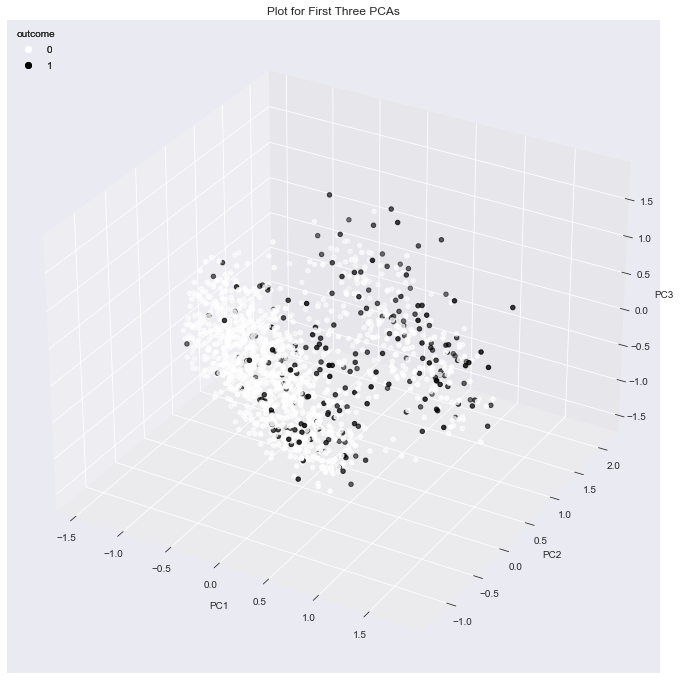

In [392]:
# Code from last project
mi_selector = SelectKBest(mutual_info_classif, k = 'all')
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
pca_df = pd.DataFrame(data = X_train_pca[:, 0:3], 
                      columns = ['PC1', 'PC2', 'PC3'])
y_train_idx = y_train.reset_index(drop = True)
pca_df['outcome'] = y_train_idx
# 3-D Scatter plot for first 3 PCAs

fig = plt.figure(figsize = (16, 12))
ax = fig.add_subplot(projection = '3d')
xp = pca_df['PC1']
yp = pca_df['PC2']
zp = pca_df['PC3']
scatters = ax.scatter(xp, yp, zp, c = pca_df['outcome'])
legend2 = ax.legend(*scatters.legend_elements(),
                    loc = 'upper left', title = 'outcome')
ax.add_artist(legend2)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('Plot for First Three PCAs')
plt.show()

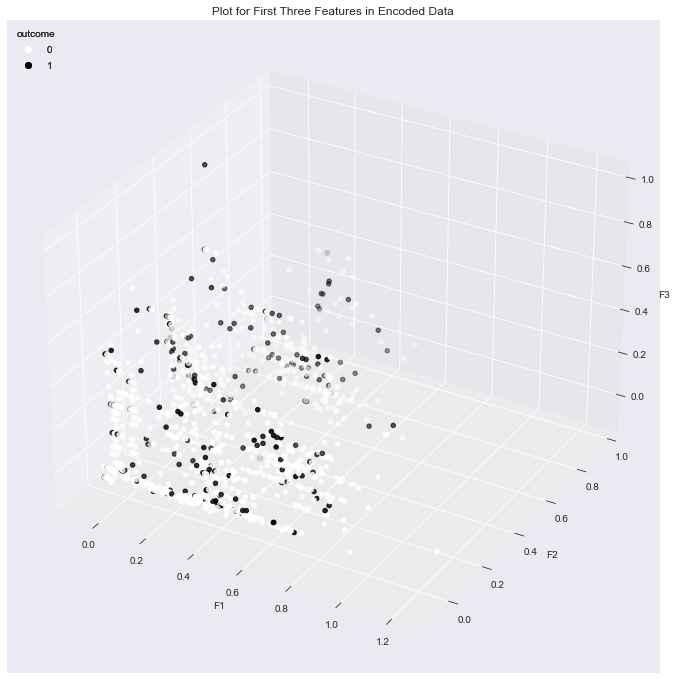

In [393]:
encode_df = pd.DataFrame(data = encoded_train_sd[:, 0:3, 0], 
                      columns = ['F1', 'F2', 'F3'])
encode_df['outcome'] = y_train_idx


fig = plt.figure(figsize = (16, 12))
ax = fig.add_subplot(projection = '3d')
xp = encode_df['F1']
yp = encode_df['F2']
zp = encode_df['F3']
scatters = ax.scatter(xp, yp, zp, c = encode_df['outcome'])
legend2 = ax.legend(*scatters.legend_elements(),
                    loc = 'upper left', title = 'outcome')
ax.add_artist(legend2)
ax.set_xlabel('F1')
ax.set_ylabel('F2')
ax.set_zlabel('F3')
plt.title('Plot for First Three Features in Encoded Data')
plt.show()


In [394]:
# These graphs show that the two anaylises are similair. With lethal outcomes most likely when the feature have higher values. 

### <center> Explore if Decoded Data Improves Preformace of Optimized CNN </center>

In [395]:
#See how the decoded data performs with luis final CNN model
prints=[]
for data_sets in decoded_data:
    history_opt1 = model_conv1D_optim.fit(data_sets, y_train_cnn, batch_size=8,
                                   validation_data=(X_test_reshaped, y_test_cnn), verbose=1,
                                  epochs=100)
    prints.append(f'mean f1 on training set: {np.mean(history_opt1.history["get_f1"])}')
    prints.append(f'mean f1 on validation set: {np.mean(history_opt1.history["val_get_f1"])}')
    pred_2 = model_conv1D_optim.predict(X_test_reshaped)
    pred_2 = np.where(pred_2 > 0.5, 1, 0)
    prints.append(classification_report(y_test_cnn, pred_2))
    prints.append(f'f1-score for unoptimized model test data: {f1_score(y_test_cnn, pred_2)}')

Epoch 1/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4091 - get_f1: 0.0692 - val_loss: 0.5079 - val_get_f1: 0.1116
Epoch 2/100
170/170 [==============================] - 0s 2ms/step - loss: 0.3897 - get_f1: 0.0722 - val_loss: 0.4480 - val_get_f1: 0.1543
Epoch 3/100
170/170 [==============================] - 0s 2ms/step - loss: 0.3791 - get_f1: 0.1359 - val_loss: 0.4615 - val_get_f1: 0.1388
Epoch 4/100
170/170 [==============================] - 0s 2ms/step - loss: 0.3710 - get_f1: 0.1306 - val_loss: 0.4243 - val_get_f1: 0.2333
Epoch 5/100
170/170 [==============================] - 0s 2ms/step - loss: 0.3551 - get_f1: 0.1790 - val_loss: 0.4257 - val_get_f1: 0.2178
Epoch 6/100
170/170 [==============================] - 0s 2ms/step - loss: 0.3526 - get_f1: 0.1884 - val_loss: 0.4252 - val_get_f1: 0.1984
Epoch 7/100
170/170 [==============================] - 0s 2ms/step - loss: 0.3493 - get_f1: 0.1525 - val_loss: 0.4318 - val_get_f1: 0.1829
Epoch 8/100
170/170 [======

170/170 [==============================] - 0s 2ms/step - loss: 0.2557 - get_f1: 0.4207 - val_loss: 1.7480 - val_get_f1: 0.2191
Epoch 60/100
170/170 [==============================] - 0s 2ms/step - loss: 0.2581 - get_f1: 0.3883 - val_loss: 1.5873 - val_get_f1: 0.2258
Epoch 61/100
170/170 [==============================] - 0s 2ms/step - loss: 0.2443 - get_f1: 0.4063 - val_loss: 1.7262 - val_get_f1: 0.2308
Epoch 62/100
170/170 [==============================] - 0s 2ms/step - loss: 0.2500 - get_f1: 0.4379 - val_loss: 1.7304 - val_get_f1: 0.2449
Epoch 63/100
170/170 [==============================] - 0s 2ms/step - loss: 0.2490 - get_f1: 0.3974 - val_loss: 1.9940 - val_get_f1: 0.2275
Epoch 64/100
170/170 [==============================] - 0s 2ms/step - loss: 0.2504 - get_f1: 0.3455 - val_loss: 2.0104 - val_get_f1: 0.2272
Epoch 65/100
170/170 [==============================] - 0s 2ms/step - loss: 0.2554 - get_f1: 0.4524 - val_loss: 1.8998 - val_get_f1: 0.2357
Epoch 66/100
170/170 [===========

170/170 [==============================] - 0s 2ms/step - loss: 0.3193 - get_f1: 0.2453 - val_loss: 0.9627 - val_get_f1: 0.2599
Epoch 18/100
170/170 [==============================] - 0s 2ms/step - loss: 0.3105 - get_f1: 0.2590 - val_loss: 1.0302 - val_get_f1: 0.2421
Epoch 19/100
170/170 [==============================] - 0s 2ms/step - loss: 0.3053 - get_f1: 0.2742 - val_loss: 0.9471 - val_get_f1: 0.2520
Epoch 20/100
170/170 [==============================] - 0s 2ms/step - loss: 0.3035 - get_f1: 0.2603 - val_loss: 1.0556 - val_get_f1: 0.2305
Epoch 21/100
170/170 [==============================] - 0s 2ms/step - loss: 0.3014 - get_f1: 0.2760 - val_loss: 1.1659 - val_get_f1: 0.2355
Epoch 22/100
170/170 [==============================] - 0s 2ms/step - loss: 0.3062 - get_f1: 0.2852 - val_loss: 1.0355 - val_get_f1: 0.2384
Epoch 23/100
170/170 [==============================] - 0s 2ms/step - loss: 0.2929 - get_f1: 0.2902 - val_loss: 0.9747 - val_get_f1: 0.2195
Epoch 24/100
170/170 [===========

170/170 [==============================] - 0s 2ms/step - loss: 0.2297 - get_f1: 0.5017 - val_loss: 1.2577 - val_get_f1: 0.2271
Epoch 76/100
170/170 [==============================] - 0s 2ms/step - loss: 0.2394 - get_f1: 0.3986 - val_loss: 1.2736 - val_get_f1: 0.2109
Epoch 77/100
170/170 [==============================] - 0s 2ms/step - loss: 0.2359 - get_f1: 0.3870 - val_loss: 1.3386 - val_get_f1: 0.1907
Epoch 78/100
170/170 [==============================] - 0s 2ms/step - loss: 0.2143 - get_f1: 0.4367 - val_loss: 1.3148 - val_get_f1: 0.1961
Epoch 79/100
170/170 [==============================] - 0s 2ms/step - loss: 0.2220 - get_f1: 0.4680 - val_loss: 1.3332 - val_get_f1: 0.2016
Epoch 80/100
170/170 [==============================] - 0s 2ms/step - loss: 0.2212 - get_f1: 0.4311 - val_loss: 1.3527 - val_get_f1: 0.2496
Epoch 81/100
170/170 [==============================] - 0s 2ms/step - loss: 0.2274 - get_f1: 0.4278 - val_loss: 1.2490 - val_get_f1: 0.2000
Epoch 82/100
170/170 [===========

Epoch 33/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4425 - get_f1: 0.0000e+00 - val_loss: 1.4679 - val_get_f1: 0.1714
Epoch 34/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4405 - get_f1: 0.0000e+00 - val_loss: 1.4667 - val_get_f1: 0.1714
Epoch 35/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4387 - get_f1: 0.0000e+00 - val_loss: 1.4645 - val_get_f1: 0.1714
Epoch 36/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4436 - get_f1: 0.0000e+00 - val_loss: 1.4626 - val_get_f1: 0.1714
Epoch 37/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4410 - get_f1: 0.0000e+00 - val_loss: 1.4607 - val_get_f1: 0.1714
Epoch 38/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4411 - get_f1: 0.0000e+00 - val_loss: 1.4599 - val_get_f1: 0.1714
Epoch 39/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4404 - get_f1: 0.0000e+00 - val_loss: 1.4577 - val_get_f1:

Epoch 90/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4402 - get_f1: 0.0000e+00 - val_loss: 1.4067 - val_get_f1: 0.1566
Epoch 91/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4393 - get_f1: 0.0000e+00 - val_loss: 1.4065 - val_get_f1: 0.1566
Epoch 92/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4400 - get_f1: 0.0000e+00 - val_loss: 1.4064 - val_get_f1: 0.1566
Epoch 93/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4406 - get_f1: 0.0000e+00 - val_loss: 1.4063 - val_get_f1: 0.1566
Epoch 94/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4405 - get_f1: 0.0000e+00 - val_loss: 1.4062 - val_get_f1: 0.1566
Epoch 95/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4398 - get_f1: 0.0000e+00 - val_loss: 1.4060 - val_get_f1: 0.1566
Epoch 96/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4412 - get_f1: 0.0000e+00 - val_loss: 1.4058 - val_get_f1:

Epoch 47/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4400 - get_f1: 0.0000e+00 - val_loss: 1.4003 - val_get_f1: 0.1837
Epoch 48/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4398 - get_f1: 0.0000e+00 - val_loss: 1.4003 - val_get_f1: 0.1837
Epoch 49/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4393 - get_f1: 0.0000e+00 - val_loss: 1.4002 - val_get_f1: 0.1837
Epoch 50/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4402 - get_f1: 0.0000e+00 - val_loss: 1.4002 - val_get_f1: 0.1837
Epoch 51/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4393 - get_f1: 0.0000e+00 - val_loss: 1.4001 - val_get_f1: 0.1837
Epoch 52/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4399 - get_f1: 0.0000e+00 - val_loss: 1.4001 - val_get_f1: 0.1837
Epoch 53/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4391 - get_f1: 0.0000e+00 - val_loss: 1.4000 - val_get_f1:

Epoch 4/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4406 - get_f1: 0.0000e+00 - val_loss: 1.3979 - val_get_f1: 0.1744
Epoch 5/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4406 - get_f1: 0.0000e+00 - val_loss: 1.3978 - val_get_f1: 0.1744
Epoch 6/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4405 - get_f1: 0.0000e+00 - val_loss: 1.3978 - val_get_f1: 0.1744
Epoch 7/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4400 - get_f1: 0.0000e+00 - val_loss: 1.3977 - val_get_f1: 0.1744
Epoch 8/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4399 - get_f1: 0.0000e+00 - val_loss: 1.3977 - val_get_f1: 0.1744
Epoch 9/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4400 - get_f1: 0.0000e+00 - val_loss: 1.3977 - val_get_f1: 0.1744
Epoch 10/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4398 - get_f1: 0.0000e+00 - val_loss: 1.3977 - val_get_f1: 0.174

Epoch 61/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4401 - get_f1: 0.0000e+00 - val_loss: 1.3974 - val_get_f1: 0.1744
Epoch 62/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4397 - get_f1: 0.0000e+00 - val_loss: 1.3976 - val_get_f1: 0.1744
Epoch 63/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4399 - get_f1: 0.0000e+00 - val_loss: 1.3978 - val_get_f1: 0.1744
Epoch 64/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4398 - get_f1: 0.0000e+00 - val_loss: 1.3975 - val_get_f1: 0.1744
Epoch 65/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4398 - get_f1: 0.0000e+00 - val_loss: 1.3973 - val_get_f1: 0.1744
Epoch 66/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4401 - get_f1: 0.0000e+00 - val_loss: 1.3979 - val_get_f1: 0.1744
Epoch 67/100
170/170 [==============================] - 0s 2ms/step - loss: 0.4398 - get_f1: 0.0000e+00 - val_loss: 1.3979 - val_get_f1:

In [396]:
for i in range(len(prints)):
    if i % 4==0:
      print(names[int(i/4)]+'\n')
    print(prints[i])
    if i % 4==0:
      print('\n')

Simple Autoencoder

mean f1 on training set: 0.35676336035132405


mean f1 on validation set: 0.23424232095479966
              precision    recall  f1-score   support

           0       0.85      0.55      0.66       286
           1       0.17      0.48      0.25        54

    accuracy                           0.54       340
   macro avg       0.51      0.51      0.46       340
weighted avg       0.74      0.54      0.60       340

f1-score for unoptimized model test data: 0.2476190476190476
Simple Autoencoder with dropout/noise

mean f1 on training set: 0.3492106302082539


mean f1 on validation set: 0.22689755275845527
              precision    recall  f1-score   support

           0       0.86      0.81      0.84       286
           1       0.24      0.31      0.27        54

    accuracy                           0.74       340
   macro avg       0.55      0.56      0.56       340
weighted avg       0.76      0.74      0.75       340

f1-score for unoptimized model test dat